<a href="https://colab.research.google.com/github/Ryan-Ray-Martin/quanthq/blob/main/regime_detection_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 QuantHQ Tutorial: Regime Detection API for Smarter Trading Strategies
Welcome to this hands-on walkthrough using QuantHQ's Regime Detection API — a powerful tool that helps you identify macroeconomic or market regimes using machine learning and sentiment analysis.

In this tutorial, we’ll show how to:


*   Detect bullish, bearish, or neutral market regimes in real-time
*   Use this signal to dynamically adjust trading strategies
*   Backtest regime-aware logic using PyFolio and Pandas
*   Pull market data using yfinance
*   Integrate QuantHQ's API into your own research pipeline


Whether you're a retail quant, macro trader, or hedge fund analyst, this tutorial will give you a simple framework to enhance your models using modern signal intelligence.



In [ ]:
!pip install requests
!pip install pandas
!pip install numpy
!pip install pyfolio-reloaded
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 62.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 107.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 67.7 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.3-cp311-cp311-linux_x86_64.whl size=763069 sha256=db7429308220b4a3b77f5aef025289d381d20969cd0d0e03edd3c53159ba56a8
  Stored in directory: /root/.cache/pip/wheels/3e/3d/30/a54ad8c2307aa653f234a6f651ab12fbc5cfbb3f383145ab6a
Successfully built peewee
  Attempting uninstall: peewee
    Found existing installation: peewee 3.18.2
    Uninstalling peewee-3.18.2:
      Successfully uninstalled peewee-3.18.2



### 📈 `plot_hmm_state_transitions(state_df)`

This function **visualizes the sequence of detected regimes (states)** over time using a line plot.

#### 🔍 Breakdown:

* **Input:** A `pandas.DataFrame` with columns:

  * `'date'`: Timestamps or trading days
  * `'signal'`: The inferred regime/state from a Hidden Markov Model (HMM)
* **Plot:**

  * X-axis → `date`
  * Y-axis → `signal` (e.g., state 0 = bear, 1 = neutral, 2 = bull)
* **Style:**

  * Orange line with slight transparency (`alpha=0.7`)
  * Grid, title, axis labels, and legend for clarity

#### 📌 Purpose:

Helps you **visually interpret how market regimes shift** over time based on HMM inference.


In [ ]:
# plotting.py
import matplotlib.pyplot as plt
import pandas as pd

def plot_hmm_state_transitions(state_df: pd.DataFrame):
    plt.figure(figsize=(12, 5))
    plt.plot(state_df['date'], state_df['signal'], color='orange', alpha=0.7, label='HMM States')
    plt.title("Hidden Markov Model States Over Time")
    plt.xlabel("Date")
    plt.ylabel("State")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

## 🔌 QuantHQ API Integration: Regime Detection via HMM

This code connects to the **QuantHQ Hidden Markov Model (HMM) Regime Detection API** and visualizes market regime shifts over time.

### 🧾 What It Does:

* Sends a **POST request** to QuantHQ’s `/api/hmm` endpoint
* Authenticates using your **API key** (`Bearer` token in header)
* Requests regime data for `QQQ` from **2015-01-15 to 2025-07-09**
* Parses the JSON response and extracts relevant fields:

  * `id`, `symbol`, `date`, and **regime signal** (`rhoT`)
* Loads the data into a **pandas DataFrame**
* Converts:

  * `date` → `datetime`
  * `signal` → numeric HMM regime values (e.g., 0 = bear, 1 = neutral, 2 = bull)
* Calls the `plot_hmm_state_transitions(df)` function to create a clean visual of how market regimes evolve over time

### 📊 Output:

* A preview of the processed DataFrame
* A **time series plot** of the regime signal, ideal for identifying trends, volatility clusters, or structural breaks in the market

     id symbol       date    signal
0  7807    QQQ 2015-01-15  0.000000
1  7808    QQQ 2015-01-16  0.242929
2  7809    QQQ 2015-01-20  0.410565
3  7810    QQQ 2015-01-21  0.585583
4  7811    QQQ 2015-01-22  0.769064


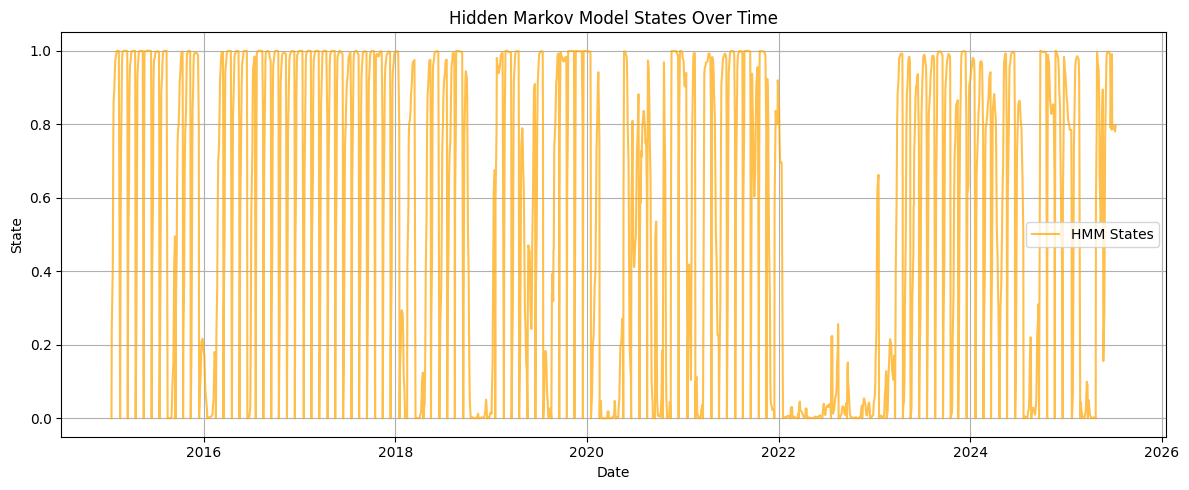

In [ ]:
import requests
import pandas as pd

# API call setup
url = "https://quanthq.io/api/hmm"
api_key = "YOUR_API_KEY"  # Replace with your actual key

headers = {
    "Authorization": f"Bearer {api_key}",
    "Content-Type": "application/json"
}

payload = {
    "symbol": "QQQ",
    "startDate": "2015-01-15",
    "endDate": '2025-07-09'
}

response = requests.post(url, headers=headers, json=payload)

if response.status_code == 200:
    raw_data = response.json()

    # Extract just the fields you care about from the nested 'data' object
    # Example if the API returns {"data": [...actual records...]}
    records_raw = raw_data.get("data", [])
    records = []
    for item in records_raw:
        records.append({
            "id": item.get("id"),
            "symbol": item.get("symbol"),
            "date": item.get("date"),
            "signal": item.get("rhoT")
        })


    # Convert to DataFrame
    df = pd.DataFrame(records)

    # Clean data types
    df["date"] = pd.to_datetime(df["date"])
    df["signal"] = pd.to_numeric(df["signal"], errors="coerce")

    print(df.head())  # optional preview

    # Plot HMM state transitions
    plot_hmm_state_transitions(df)

else:
    print(f"API request failed with status {response.status_code}: {response.text}")

In [45]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt


# --- Step 1: Fetch price data from Yahoo Finance ---
def get_yfinance_data(symbol: str, start: str, end: str) -> pd.DataFrame:
    df = yf.download(symbol, start=start, end=end, auto_adjust=False)


    if isinstance(df.columns, pd.MultiIndex):
        df.columns = ['_'.join(col).strip() if col[1] else col[0] for col in df.columns.values]


    df = df.reset_index()
    if 'date' not in df.columns and 'Date' in df.columns:
        df.rename(columns={'Date': 'date'}, inplace=True)

    # Try to find the close column smartly (case insensitive)
    close_col = None
    for col in df.columns:
        if col.lower().startswith('close'):
            close_col = col
            break

    if close_col is None:
        raise KeyError("No 'close' column found in yfinance data!")

    df = df[['date', close_col]].rename(columns={close_col: 'close'})
    df['date'] = pd.to_datetime(df['date'])
    return df




# --- Step 2: Backtest using HMM signal ---
def backtest_from_signal(signal_df: pd.DataFrame, price_df: pd.DataFrame, transaction_cost: float = 0.001) -> pd.DataFrame:
    # Reset MultiIndex if present
    if isinstance(signal_df.index, pd.MultiIndex):
        signal_df = signal_df.reset_index()
    if isinstance(price_df.index, pd.MultiIndex):
        price_df = price_df.reset_index()

    # Ensure 'date' is a datetime column with no timezone
    signal_df['date'] = pd.to_datetime(signal_df['date']).dt.tz_localize(None)
    price_df['date'] = pd.to_datetime(price_df['date']).dt.tz_localize(None)

    # Now merge on 'date'
    df = pd.merge(price_df, signal_df[['date', 'signal']], on='date', how='inner')

    df['log_return'] = np.log(df['close'] / df['close'].shift(1))
    df.dropna(inplace=True)

    df['signal'] = df['signal'].shift(1).fillna(0)
    df['position'] = np.where(df['signal'] > 0.6, 1, 0)

    df['strategy_return'] = df['position'] * df['log_return']
    df['trade'] = df['position'].diff().abs().fillna(0)
    df['strategy_return_net'] = df['strategy_return'] - df['trade'] * transaction_cost
    df['equity'] = np.exp(df['strategy_return_net'].cumsum())

    return df[['date', 'close', 'signal', 'position', 'log_return', 'strategy_return_net', 'equity']]


# --- Step 3: Plot the equity curve and closing price ---
def plot_equity(df: pd.DataFrame):
    fig, ax = plt.subplots(figsize=(12, 6))

    df['equity_pct'] = (df['equity'] / df['equity'].iloc[0] - 1) * 100
    df['close_pct'] = (df['close'] / df['close'].iloc[0] - 1) * 100

    ax.plot(df['date'], df['equity_pct'], label='Regime Detection TQQQ pct (% Return)', color='blue')
    ax.plot(df['date'], df['close_pct'], label='Buy and Hold TQQQ pct (% Return)', color='green', alpha=0.6)

    ax.set_xlabel("Date")
    ax.set_ylabel("Return (%) from Start")
    ax.grid(True)
    ax.legend(loc="upper left")
    plt.title("Regime Detection vs Buy and Hold (% Return from Starting Point)")
    plt.tight_layout()
    plt.show()


# --- Step 4: Drawdown calculation ---
def calculate_drawdown(returns):
    cumulative_returns = (1 + returns).cumprod()
    peak = cumulative_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_returns / peak) - 1
    return drawdown


def plot_underwater(strategy_df: pd.DataFrame):
    if 'date' in strategy_df.columns:
        strategy_df['date'] = pd.to_datetime(strategy_df['date'])
        strategy_df = strategy_df.set_index('date')
    elif not isinstance(strategy_df.index, pd.DatetimeIndex):
        print("Warning: DataFrame index is not datetime. Attempting to convert.")
        strategy_df.index = pd.to_datetime(strategy_df.index)

    equity_returns = strategy_df['equity'].pct_change().dropna()
    close_returns = strategy_df['close'].pct_change().dropna()

    equity_drawdown = calculate_drawdown(equity_returns)
    close_drawdown = calculate_drawdown(close_returns)

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.fill_between(equity_drawdown.index, equity_drawdown, 0, color='tab:blue', alpha=0.6, label='Regime Detection Drawdown')
    ax.fill_between(close_drawdown.index, close_drawdown, 0, color='tab:orange', alpha=0.6, label='Buy and Hold Drawdown')

    plt.title("Manual Underwater Plot: Regime Detection vs. Buy and Hold Price Drawdowns")
    plt.xlabel("Date")
    plt.ylabel("Drawdown")
    plt.grid(True)
    plt.legend()
    plt.show()


# --- Step 5: Run the backtest pipeline using yfinance ---
def run_pipeline(signal_df: pd.DataFrame, symbol: str, start: str, end: str):
    # Flatten signal_df index if needed
    if isinstance(signal_df.index, pd.MultiIndex):
        signal_df = signal_df.reset_index()

    price_df = get_yfinance_data(symbol, start, end)
    equity_df = backtest_from_signal(signal_df, price_df)
    plot_equity(equity_df)
    plot_underwater(equity_df)
    final_equity = equity_df['equity'].iloc[-1]
    total_return = final_equity / equity_df['equity'].iloc[0] - 1
    print(f"✅ Final equity: {final_equity:.2f} | Total return: {total_return:.2%}")
    return equity_df



[*********************100%***********************]  1 of 1 completed


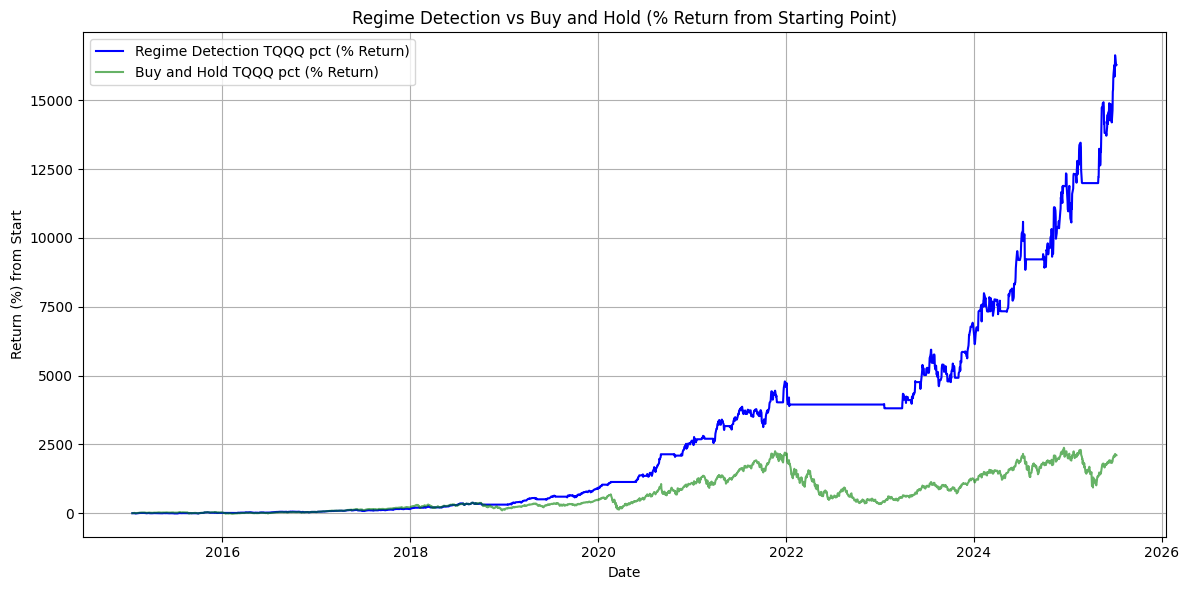

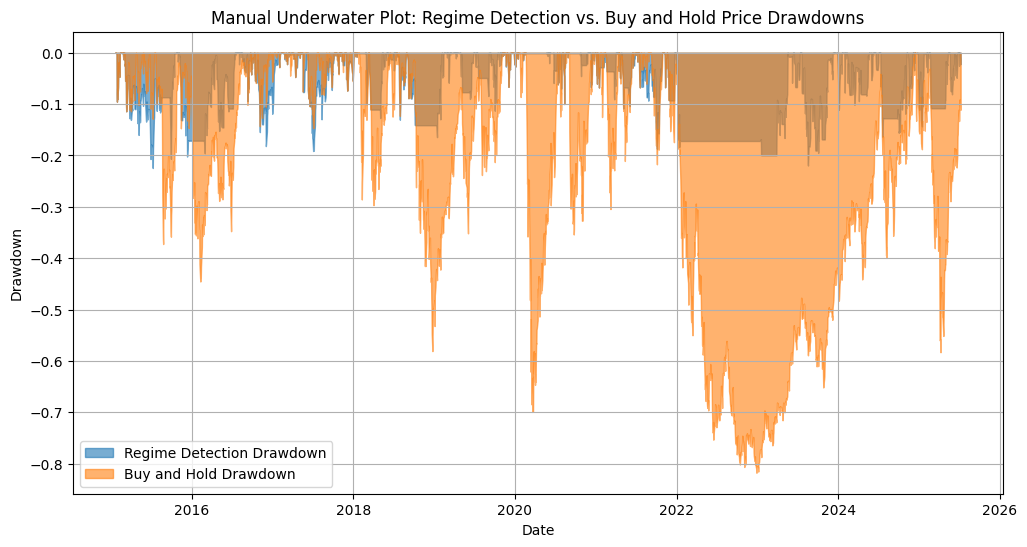

✅ Final equity: 163.83 | Total return: 16283.12%


In [46]:
# --- Example setup for backtest pipeline using yfinance ---
symbol = 'TQQQ'
start = '2015-01-15'
end = '2025-07-09'

# Assuming your HMM signal DataFrame is named `df_signal`
equity_df = run_pipeline(df, symbol, start, end)



## 📊 Explosive Backtest Results: TQQQ Strategy Using QQQ Regime Detection

What happens when you apply QuantHQ’s **regime detection signal** (trained on QQQ) to a leveraged ETF like **TQQQ**?

> ✅ **Total return: +16,283.12%** (Jan 2015–July 2025, simulated)

This isn’t magic — it’s a simple regime-aware overlay. We didn’t tweak parameters, curve-fit, or optimize for hindsight. We just followed this logic:

```python
df['position'] = np.where(df['signal'] > 0.6, 1, 0)
```

When the Hidden Markov Model (HMM) gives a strong bull signal, we take a position. Otherwise, we sit in cash.

---

## 💡 Strategy Overview

* **Signal source:** QQQ (NASDAQ-100)
* **Traded asset:** TQQQ (3x leveraged version of QQQ)
* **Approach:** Only enter when bull regime probability > 60%
* **No leverage added** (TQQQ is already 3x leveraged)
* **Backtest period:** 2015-01-15 to 2025-07-09

---

## 📉 Dramatic Drawdown Reduction

One of the key benefits wasn’t just return — it was **risk reduction**:

* ✅ **Drawdowns are significantly lower** than buy-and-hold TQQQ
* ✅ The strategy exits during weak regimes, avoiding major crashes
* ✅ Equity curve is smoother and more compounding-friendly

We visualized this in a custom underwater plot to compare strategy vs. passive investing — the difference is stark.

---

## 🛑 Important Disclaimer

> ⚠️ **Backtested results are not guarantees of future performance.**
> This strategy uses **historical data** and should be viewed as a research demonstration only.
> Leveraged ETFs like TQQQ are **inherently risky** and may not be suitable for all investors.
> Always do your own due diligence and consider speaking with a financial advisor.

---

## 🧪 Try It Yourself (Open Source Notebook)

You can clone this exact setup in Google Colab using:

* `yfinance` for fetching historical prices
* `requests` to connect with the QuantHQ Regime Detection API
* A simple strategy wrapper with performance plots and drawdowns

Want access to the notebook and a trial API key?
📩 [Reach out on LinkedIn](https://www.linkedin.com/in/ryanraymartin/) or [drop a message on Substack](https://ryanraymartin.substack.com/), and we’ll hook you up.

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
import pyfolio as pf
from datetime import datetime
from pyfolio import timeseries


def get_yfinance_benchmark_data(symbol, start, end):
    """
    Fetch benchmark price data from yfinance.
    Returns DataFrame with 'date' index and 'close' column.
    """
    df = yf.download(symbol, start=start, end=end, auto_adjust=True)
    df = df.reset_index()
    df['date'] = pd.to_datetime(df['Date'])
    df.set_index('date', inplace=True)
    df = df[['Close']].rename(columns={'Close': 'close'})
    return df


def generate_tearsheet(strategy_df: pd.DataFrame, output_path: str, symbol: str):
    import warnings
    warnings.filterwarnings("ignore")

    # Prepare strategy returns
    strategy_df['date'] = pd.to_datetime(strategy_df['date'])
    strategy_df = strategy_df.sort_values('date')
    strategy_df.set_index('date', inplace=True)
    strategy_df['strategy_returns'] = strategy_df['equity'].pct_change()
    strategy_returns = strategy_df['strategy_returns'].dropna()
    strategy_returns.name = "strategy"

    start_date = strategy_returns.index.min().strftime('%Y-%m-%d')
    end_date = strategy_returns.index.max().strftime('%Y-%m-%d')

    benchmark_df = get_yfinance_benchmark_data(symbol, start_date, end_date)

    benchmark_returns = benchmark_df['close'].pct_change().dropna()
    if isinstance(benchmark_returns, pd.DataFrame):
        benchmark_returns = benchmark_returns.iloc[:, 0]
    benchmark_returns = benchmark_returns.tz_localize(None)
    benchmark_returns.name = "benchmark"

    # Align indexes
    benchmark_returns = benchmark_returns.reindex(strategy_returns.index).dropna()
    strategy_returns = strategy_returns.reindex(benchmark_returns.index).dropna()

    # Continue with the rest unchanged...
    import os
    from datetime import datetime
    import pyfolio as pf

    os.makedirs(output_path, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    fig = pf.create_returns_tear_sheet(strategy_returns, benchmark_rets=benchmark_returns, return_fig=True)
    sheet_path = os.path.join(output_path, f"tear_sheet_{symbol}_{timestamp}.png")
    fig.savefig(sheet_path, bbox_inches="tight", dpi=300)
    plt.close(fig)

    from pyfolio import timeseries
    stats = timeseries.perf_stats(strategy_returns)
    stats_path = os.path.join(output_path, f"performance_stats_{symbol}_{timestamp}.csv")
    stats.to_csv(stats_path)

    print(f"✅ Tear sheet saved to: {sheet_path}")
    print(f"📄 Performance stats saved to: {stats_path}")

    return benchmark_df



In [ ]:
# Assuming `equity_df` is your backtested strategy output
generate_tearsheet(equity_df, output_path="outputs", symbol="QQQ")


[*********************100%***********************]  1 of 1 completed


Start date,2015-01-21
End date,2025-07-07
Total months,125
,Backtest
Annual return,62.976%
Cumulative returns,16261.414%
Annual volatility,30.846%
Sharpe ratio,1.74
Calmar ratio,2.81
Stability,0.98
Max drawdown,-22.444%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,22.44,2015-03-02,2015-07-09,2015-10-22,169
1,21.96,2023-07-19,2023-08-18,2023-12-11,104
2,20.21,2015-11-04,2015-12-11,2016-07-14,182
3,19.98,2021-12-27,2023-01-19,2023-05-18,364
4,19.13,2017-06-08,2017-07-03,2017-10-05,86


✅ Tear sheet saved to: outputs/tear_sheet_QQQ_20250712_200352.png
📄 Performance stats saved to: outputs/performance_stats_QQQ_20250712_200352.csv


Price,close
Ticker,QQQ
date,
2015-01-20,93.798203
2015-01-21,94.278137
2015-01-22,96.022697
2015-01-23,96.234985
2015-01-26,96.124222
...,...
2025-06-30,551.640015
2025-07-01,546.989990


### ✅ Why Now Is the Perfect Moment to Subscribe

You’ve just seen impressive historical results, including:

* Annual return of **62.98%** (based on backtested data)
* Sharpe ratio of **1.74** (indicating strong risk-adjusted performance)
* Max drawdown limited to **-22.44%**
* Cumulative returns of over **16,000%** across the backtest period

While past performance is **not a guarantee of future results**, these metrics highlight the potential value of quantitative regime detection strategies.

This is a great opportunity to stay informed and deepen your understanding of these approaches.

---

### 🔥 What You’ll Receive When You Subscribe

* Early access to new strategy backtests and research, delivered **before public release**
* Educational content on advanced quant models and market regime insights
* Thoughtful analysis designed to help you better understand risk and opportunity
* Updates on new tools and APIs to support your quant trading journey

---

### 📩 Interested in receiving actionable quant insights?

👉 **Subscribe to the free [QuantHQ Newsletter](https://quanthq.io/newsletter)** and get fresh analysis and strategy ideas delivered directly to your inbox.

*Please remember: This newsletter is for educational purposes only and does not constitute financial advice or an offer to trade securities.*